# Merge Dataset train & valid

In [2]:
import os
import shutil
from pathlib import Path

base_dir = Path('/kaggle/input/chest-ctscan-images/Data')
output_dir = Path('datasetMerge')

canonical_classes = [
    'adenocarcinoma',
    'large.cell.carcinoma',
    'normal',
    'squamous.cell.carcinoma'
]

output_dir.mkdir(exist_ok=True)

for class_name in canonical_classes:
    (output_dir / class_name).mkdir(exist_ok=True)

total_files_copied = 0

for source_class_dir in base_dir.glob('*/*'):
    if not source_class_dir.is_dir():
        continue
    
    raw_name = source_class_dir.name
    
    target_class_name = next(
        (name for name in canonical_classes if raw_name.startswith(name)),
        None
    )
    
    if not target_class_name:
        continue
    
    parent_dir_name = source_class_dir.parent.name.lower()
    if 'train' not in parent_dir_name and 'valid' not in parent_dir_name:
        continue

    destination_path = output_dir / target_class_name
    destination_path.mkdir(exist_ok=True)
    
    for source_file in source_class_dir.glob('*'):
        if source_file.is_file():
            dest_file = destination_path / source_file.name
            
            if dest_file.exists():
                continue
            
            shutil.copy2(source_file, dest_file)
            total_files_copied += 1

# ============================================================================
# RINGKASAN HASIL
# ============================================================================
print("\n" + "=" * 70)
print("PROSES SELESAI!")
print("=" * 70)
print(f"Total file yang berhasil disalin: {total_files_copied}")
print(f"Semua data tergabung di folder: '{output_dir}'")

# Statistik per kelas
print("\n" + "=" * 70)
print("Distribusi Data per Kelas (TRAIN + VALID Merged):")
print("=" * 70)

total_unique_files = 0
for class_name in canonical_classes:
    class_path = output_dir / class_name
    if class_path.exists():
        num_files = len(list(class_path.glob('*')))
        total_unique_files += num_files
        print(f"  {class_name:30s}: {num_files:4d} images")

print("-" * 70)
print(f"  {'TOTAL FILES':30s}: {total_unique_files:4d} images")
print("=" * 70)


PROSES SELESAI!
Total file yang berhasil disalin: 0
Semua data tergabung di folder: 'datasetMerge'

Distribusi Data per Kelas (TRAIN + VALID Merged):
  adenocarcinoma                :  218 images
  large.cell.carcinoma          :  136 images
  normal                        :  151 images
  squamous.cell.carcinoma       :  170 images
----------------------------------------------------------------------
  TOTAL FILES                   :  675 images


# Spliting Dataset (80% train, 20% valid)

In [3]:
!pip install split-folders -q
import splitfolders
from pathlib import Path

input_folder = 'datasetMerge'
output_folder = 'datasetSplit'

splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42,
    ratio=(0.8, 0.2),  # 80% train, 20% val
    group_prefix=None,
    move=False
)

print("Data splitting selesai!")
print(f"Output folder: {output_folder}")

def verify_split(base_path):
    """Verifikasi distribusi data setelah splitting"""
    splits = ['train', 'val']
    
    print("\n" + "="*70)
    print("VERIFIKASI HASIL SPLITTING (80:20)")
    print("="*70)
    
    total_all = 0
    split_totals = {}
    
    for split in splits:
        split_path = Path(base_path) / split
        if not split_path.exists():
            continue
            
        print(f"\n{split.upper()} SET:")
        print("-"*70)
        
        total = 0
        for class_dir in sorted(split_path.iterdir()):
            if class_dir.is_dir():
                count = len(list(class_dir.glob('*')))
                total += count
                print(f"  {class_dir.name:30s}: {count:3d} images")
        
        split_totals[split] = total
        total_all += total
        print(f"  {'TOTAL':30s}: {total:3d} images")
    
    # Tampilkan statistik distribusi
    print("\n" + "="*70)
    print("STATISTIK DISTRIBUSI:")
    print("="*70)
    for split, total in split_totals.items():
        percentage = (total / total_all) * 100
        print(f"  {split.upper():10s}: {total:3d} images ({percentage:.1f}%)")
    print(f"  {'TOTAL':10s}: {total_all:3d} images (100.0%)")
    print("="*70)

verify_split(output_folder)

Copying files: 675 files [00:00, 3161.01 files/s]

Data splitting selesai!
Output folder: datasetSplit

VERIFIKASI HASIL SPLITTING (80:20)

TRAIN SET:
----------------------------------------------------------------------
  adenocarcinoma                : 174 images
  large.cell.carcinoma          : 108 images
  normal                        : 120 images
  squamous.cell.carcinoma       : 136 images
  TOTAL                         : 538 images

VAL SET:
----------------------------------------------------------------------
  adenocarcinoma                :  44 images
  large.cell.carcinoma          :  28 images
  normal                        :  31 images
  squamous.cell.carcinoma       :  34 images
  TOTAL                         : 137 images

STATISTIK DISTRIBUSI:
  TRAIN     : 538 images (79.7%)
  VAL       : 137 images (20.3%)
  TOTAL     : 675 images (100.0%)


# Image Preprocessing & Augmentation Data

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),    
    transforms.RandomRotation(15),             
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/train',
    transform=train_transform
)

val_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/val',
    transform=val_transform
)

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Training samples   : {len(train_dataset)}")
print(f"Validation samples : {len(val_dataset)}")
print(f"\nClass mapping: {train_dataset.class_to_idx}")

DATASET LOADED
Training samples   : 538
Validation samples : 137

Class mapping: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [5]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

def compute_class_weights(dataset):
    """
    Compute class weights untuk handling imbalanced dataset.
    
    Metode: Inverse frequency weighting
    weight_class_i = total_samples / (num_classes * samples_in_class_i)
    """
    targets = [label for _, label in dataset]
    class_counts = Counter(targets)
    
    total_samples = len(targets)
    num_classes = len(class_counts)
    
    print("\n" + "="*70)
    print("ANALISIS DISTRIBUSI KELAS")
    print("="*70)
    
    # Hitung weight per kelas
    class_weights = []
    for class_idx in sorted(class_counts.keys()):
        count = class_counts[class_idx]
        weight = total_samples / (num_classes * count)
        class_weights.append(weight)
        
        class_name = list(dataset.class_to_idx.keys())[class_idx]
        percentage = (count / total_samples) * 100
        print(f"{class_name:30s}: {count:3d} samples ({percentage:5.2f}%) | weight: {weight:.4f}")
    
    class_weights = torch.FloatTensor(class_weights)
    
    # Sample weights untuk WeightedRandomSampler
    sample_weights = [class_weights[label] for label in targets]
    
    return class_weights, sample_weights

# Compute weights
class_weights, sample_weights = compute_class_weights(train_dataset)

# WeightedRandomSampler untuk over-sampling kelas minoritas
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


ANALISIS DISTRIBUSI KELAS
adenocarcinoma                : 174 samples (32.34%) | weight: 0.7730
large.cell.carcinoma          : 108 samples (20.07%) | weight: 1.2454
normal                        : 120 samples (22.30%) | weight: 1.1208
squamous.cell.carcinoma       : 136 samples (25.28%) | weight: 0.9890


In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Gunakan weighted sampler
    num_workers=0,
    pin_memory=True,
    drop_last=True  # Drop incomplete batch untuk stabilitas training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("\n" + "="*70)
print("DATALOADERS CREATED")
print("="*70)
print(f"Batch size         : {BATCH_SIZE}")
print(f"Training batches   : {len(train_loader)}")
print(f"Validation batches : {len(val_loader)}")


DATALOADERS CREATED
Batch size         : 32
Training batches   : 16
Validation batches : 5


Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):


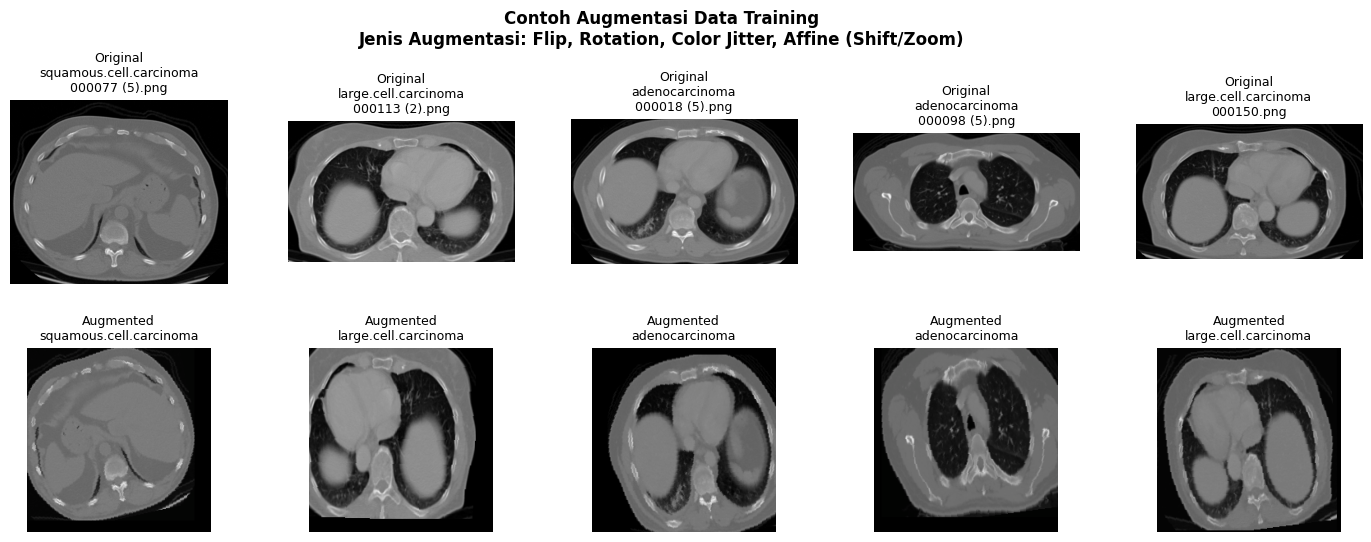

In [7]:
import matplotlib.pyplot as plt
import torch
import random  # ⬅️ tambahkan baris ini!
from torchvision import transforms
from PIL import Image

def detect_applied_augmentations(transform_pipeline):
    """Deteksi jenis augmentasi yang digunakan."""
    aug_list = []
    for t in transform_pipeline.transforms:
        name = t.__class__.__name__
        if "RandomRotation" in name:
            aug_list.append("Rotation")
        elif "RandomHorizontalFlip" in name:
            aug_list.append("Flip")
        elif "RandomAffine" in name:
            aug_list.append("Affine (Shift/Zoom)")
        elif "ColorJitter" in name:
            aug_list.append("Color Jitter")
        elif "RandomPerspective" in name:
            aug_list.append("Perspective")
        elif "RandomGrayscale" in name:
            aug_list.append("Grayscale")
        elif "RandomErasing" in name:
            aug_list.append("Erasing")
    return ", ".join(aug_list) if aug_list else "No Augmentation"


def visualize_multiple_augmentations_horizontal(dataset, num_pairs=5):
    """
    Menampilkan 5 pasangan gambar original dan hasil augmentasinya
    dengan layout horizontal: Original1 | Aug1 | Original2 | Aug2 ...
    """
    # Ambil sample acak sejumlah num_pairs
    indices = random.sample(range(len(dataset)), num_pairs)
    transform_pipeline = dataset.transform
    aug_types = detect_applied_augmentations(transform_pipeline)

    # Denormalisasi agar hasil augmentasi tampil natural
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Buat grid: 2 baris (Original + Augmented), kolom = num_pairs
    fig, axes = plt.subplots(2, num_pairs, figsize=(3.5 * num_pairs, 6))
    fig.suptitle(
        f"Contoh Augmentasi Data Training\nJenis Augmentasi: {aug_types}",
        fontsize=12, fontweight='bold'
    )

    for col, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        class_name = list(dataset.class_to_idx.keys())[label]

        # Buka gambar original
        original_img = Image.open(img_path).convert("RGB")

        # Terapkan augmentasi
        aug_img, _ = dataset[idx]
        aug_img = inv_normalize(aug_img)
        aug_img = torch.clamp(aug_img, 0, 1).permute(1, 2, 0).numpy()

        # Baris pertama → Original
        axes[0, col].imshow(original_img)
        axes[0, col].set_title(f"Original\n{class_name}\n{img_path.split('/')[-1]}", fontsize=9)
        axes[0, col].axis("off")

        # Baris kedua → Augmented
        axes[1, col].imshow(aug_img)
        axes[1, col].set_title(f"Augmented\n{class_name}", fontsize=9)
        axes[1, col].axis("off")

    plt.subplots_adjust(wspace=0.25, hspace=0.35, top=0.83)
    plt.savefig("horizontal_augmentations.png", dpi=150, bbox_inches="tight")
    plt.show()

# 🔹 Jalankan fungsi
print("Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):")
visualize_multiple_augmentations_horizontal(train_dataset, num_pairs=5)

In [8]:
def estimate_effective_dataset_size(original_size, num_augmentations=15):
    """
    Estimasi effective dataset size dengan augmentasi.
    
    Args:
        original_size: Jumlah gambar asli
        num_augmentations: Estimasi jumlah variasi unik per gambar
    """
    effective_size = original_size * num_augmentations
    
    print("\n" + "="*70)
    print("ESTIMASI EFFECTIVE DATASET SIZE")
    print("="*70)
    print(f"Original training images    : {original_size}")
    print(f"Augmentation variations     : ~{num_augmentations}x per image")
    print(f"Effective dataset size      : ~{effective_size:,} unique variations")
    print(f"\nDengan augmentasi, model akan melihat variasi berbeda setiap epoch,")
    print(f"sehingga mengurangi overfitting meskipun dataset kecil.")

estimate_effective_dataset_size(len(train_dataset))


ESTIMASI EFFECTIVE DATASET SIZE
Original training images    : 538
Augmentation variations     : ~15x per image
Effective dataset size      : ~8,070 unique variations

Dengan augmentasi, model akan melihat variasi berbeda setiap epoch,
sehingga mengurangi overfitting meskipun dataset kecil.


# Training Model efficientformerV2_s2

In [9]:
!pip install timm -q

import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Using device: cuda


In [24]:
EPOCHS = 50
WARMUP_EPOCHS = 5
LR_BASE = 1e-4
WEIGHT_DECAY = 1e-4
TRANSFER_STRATEGY = 'full'  # full/partial/freeze_head
PRETRAINED = True
OUTPUT_DIR = '/kaggle/working/efficientformer_LearningRate'
os.makedirs(OUTPUT_DIR, exist_ok=True)

num_classes = len(train_dataset.classes)
print("Detected classes:", train_dataset.classes)

Detected classes: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [25]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    loop = tqdm(loader, desc=f"Train E{epoch}", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        if device.type == 'cuda':
            ctx = torch.amp.autocast('cuda')
        else:
            from contextlib import nullcontext
            ctx = nullcontext()

        with ctx:
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc


def validate_one_epoch(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=f"Val E{epoch}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            if device.type == 'cuda':
                ctx = torch.amp.autocast('cuda')
            else:
                from contextlib import nullcontext
                ctx = nullcontext()

            with ctx:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

In [26]:
import json

def train_model(model_name, train_loader, val_loader):
    print(f"\n🚀 Training model: {model_name} \n")

    model = timm.create_model(model_name, pretrained=PRETRAINED, num_classes=num_classes)
    model.to(device)

    # Atur fine-tuning strategy
    FROZEN_EXCLUDE_KEYWORDS = ['head', 'classifier', 'fc']
    if TRANSFER_STRATEGY == 'freeze_head':
        for name, p in model.named_parameters():
            p.requires_grad = False
            if any(k in name.lower() for k in FROZEN_EXCLUDE_KEYWORDS):
                p.requires_grad = True
        print("Strategy: freeze_head → hanya head/classifier yang dilatih.")
    elif TRANSFER_STRATEGY == 'partial':
        params = list(model.named_parameters())
        cutoff = int(len(params) * 0.7)
        for idx, (name, p) in enumerate(params):
            p.requires_grad = False if idx < cutoff else True
        print("Strategy: partial fine-tune → layer awal dibekukan, layer akhir dilatih.")
    else:  # full
        for p in model.parameters():
            p.requires_grad = True
        print("Strategy: full fine-tune → semua parameter dilatih.")

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, EPOCHS + 1):
        if epoch <= WARMUP_EPOCHS:
            warmup_factor = epoch / float(WARMUP_EPOCHS)
            for g in optimizer.param_groups:
                g['lr'] = LR_BASE * warmup_factor

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, epoch)
        if epoch > WARMUP_EPOCHS:
            scheduler.step()
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'best_{model_name}_{LR_BASE}.pth'))
            print(f"✅ Model terbaik {model_name} disimpan.")

    print(f"Training selesai untuk {model_name}. Best val_loss: {best_val_loss:.4f}\n")

    history_path = os.path.join(
    OUTPUT_DIR,
    f"history_{model_name}_{LR_BASE}.json"
    )
    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)
    
    print(f"📁 History training disimpan ke {history_path}")
    
    return history

# =============================
# 6️⃣ Jalankan Training
# =============================
hist_v2_aug = train_model('efficientformerv2_s2', train_loader, val_loader)



🚀 Training model: efficientformerv2_s2 

Strategy: full fine-tune → semua parameter dilatih.


/tmp/ipykernel_124/705342479.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01: Train Acc=0.2969 | Val Acc=0.3504
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02: Train Acc=0.4414 | Val Acc=0.4745
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03: Train Acc=0.5684 | Val Acc=0.5036
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04: Train Acc=0.6270 | Val Acc=0.3942


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05: Train Acc=0.5645 | Val Acc=0.4526


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06: Train Acc=0.6406 | Val Acc=0.4672


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07: Train Acc=0.6738 | Val Acc=0.6496


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08: Train Acc=0.7266 | Val Acc=0.7226


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09: Train Acc=0.7793 | Val Acc=0.8102


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.8262 | Val Acc=0.8175


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.9004 | Val Acc=0.7810


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.9258 | Val Acc=0.8175


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.9336 | Val Acc=0.8613


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.9492 | Val Acc=0.8978


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.9707 | Val Acc=0.8978


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.9609 | Val Acc=0.9051


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.9746 | Val Acc=0.9197


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.9707 | Val Acc=0.9270


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9727 | Val Acc=0.9343


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9629 | Val Acc=0.9270


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9707 | Val Acc=0.9416


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9863 | Val Acc=0.9124


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9922 | Val Acc=0.9270


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9863 | Val Acc=0.9270


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Acc=0.9746 | Val Acc=0.9197


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9824 | Val Acc=0.9270


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Acc=0.9883 | Val Acc=0.9270


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9941 | Val Acc=0.9416


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Acc=0.9902 | Val Acc=0.9343


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Acc=0.9883 | Val Acc=0.9270


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Acc=0.9863 | Val Acc=0.9270


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Acc=0.9902 | Val Acc=0.9270


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Acc=0.9902 | Val Acc=0.9489


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Acc=0.9902 | Val Acc=0.9489


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Acc=0.9824 | Val Acc=0.9489


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Acc=0.9961 | Val Acc=0.9416


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Acc=0.9805 | Val Acc=0.9489


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Acc=0.9980 | Val Acc=0.9270


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Acc=0.9902 | Val Acc=0.9562


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Acc=0.9941 | Val Acc=0.9489


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Acc=0.9980 | Val Acc=0.9416


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Acc=0.9902 | Val Acc=0.9416


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Acc=0.9922 | Val Acc=0.9489


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Acc=0.9902 | Val Acc=0.9562


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Acc=1.0000 | Val Acc=0.9635


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Acc=0.9883 | Val Acc=0.9562


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Acc=0.9863 | Val Acc=0.9489


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Acc=0.9844 | Val Acc=0.9416


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Acc=0.9961 | Val Acc=0.9416


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Acc=0.9961 | Val Acc=0.9416
Training selesai untuk efficientformerv2_s2. Best val_loss: 1.0682

📁 History training disimpan ke /kaggle/working/efficientformer_LearningRate/history_efficientformerv2_s2_0.0001.json


# Evaluasi Model


📊 CLASSIFICATION REPORT (VALIDATION SET)
                         precision    recall  f1-score   support

         adenocarcinoma       0.25      0.02      0.04        44
   large.cell.carcinoma       0.52      0.82      0.64        28
                 normal       0.79      0.87      0.83        31
squamous.cell.carcinoma       0.45      0.74      0.56        34

               accuracy                           0.55       137
              macro avg       0.51      0.61      0.52       137
           weighted avg       0.48      0.55      0.47       137



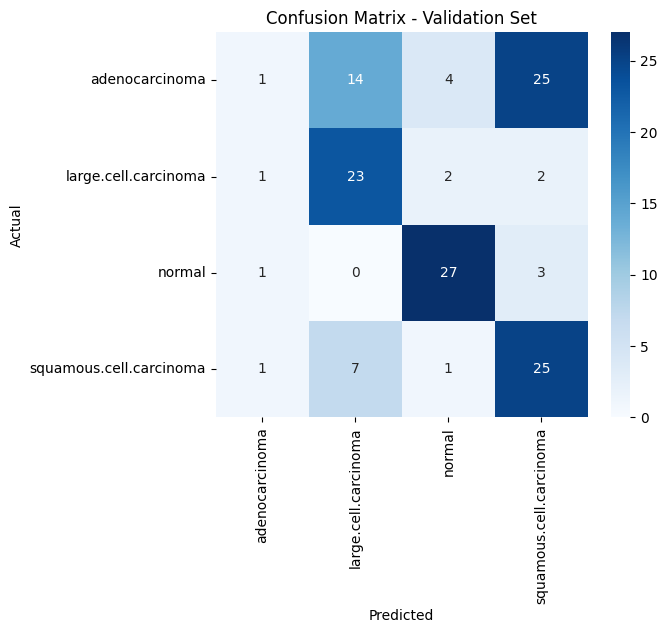

In [27]:
from sklearn.metrics import classification_report
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load model terbaik
model_path = "/kaggle/working/efficientformer_LearningRate/best_efficientformerv2_s2_0.0001.pth"

model = timm.create_model('efficientformerv2_s2', pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n📊 CLASSIFICATION REPORT (VALIDATION SET)")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

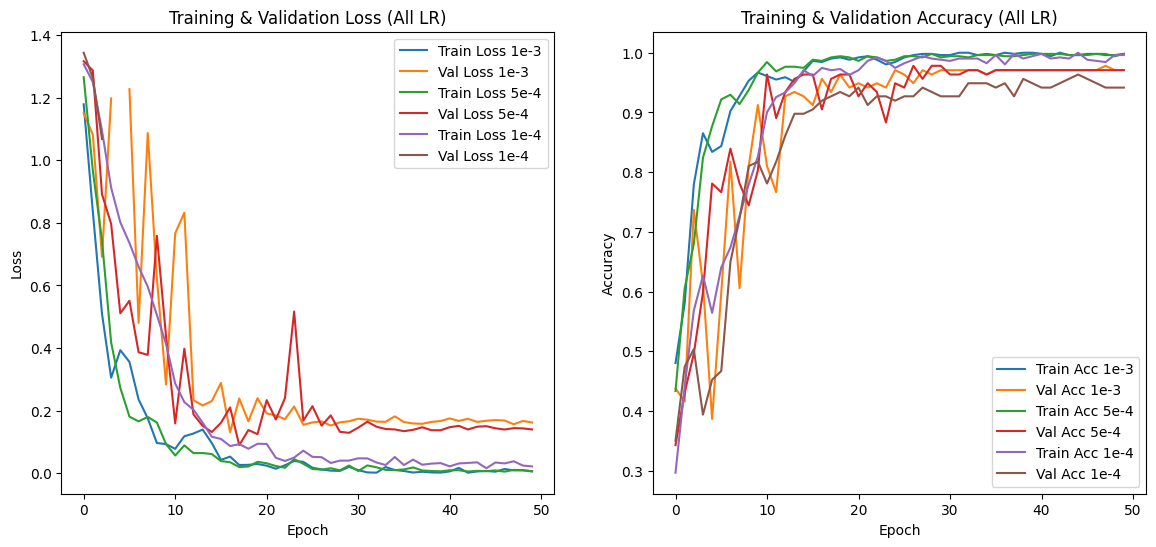

In [30]:
import json
import matplotlib.pyplot as plt

# Path folder hasil training
base_path = "/kaggle/working/efficientformer_LearningRate"

# Load semua file history berdasarkan learning rate
histories = {
    "1e-3": json.load(open(f"{base_path}/history_efficientformerv2_s2_0.001.json")),
    "5e-4": json.load(open(f"{base_path}/history_efficientformerv2_s2_0.0005.json")),
    "1e-4": json.load(open(f"{base_path}/history_efficientformerv2_s2_0.0001.json")),
}

plt.figure(figsize=(14,6))

# ---- LOSS ----
plt.subplot(1,2,1)
for lr, h in histories.items():
    plt.plot(h["train_loss"], label=f"Train Loss {lr}")
    plt.plot(h["val_loss"], label=f"Val Loss {lr}")
plt.title("Training & Validation Loss (All LR)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ---- ACC ----
plt.subplot(1,2,2)
for lr, h in histories.items():
    plt.plot(h["train_acc"], label=f"Train Acc {lr}")
    plt.plot(h["val_acc"], label=f"Val Acc {lr}")
plt.title("Training & Validation Accuracy (All LR)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

✅ Using device: cuda



📊 LR_1e-4 → Test Accuracy: 0.4921


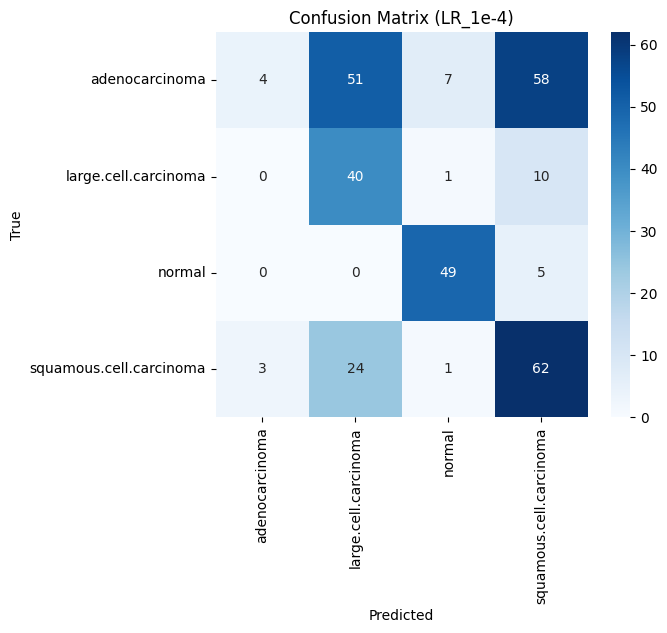

                         precision    recall  f1-score   support

         adenocarcinoma       0.57      0.03      0.06       120
   large.cell.carcinoma       0.35      0.78      0.48        51
                 normal       0.84      0.91      0.88        54
squamous.cell.carcinoma       0.46      0.69      0.55        90

               accuracy                           0.49       315
              macro avg       0.56      0.60      0.49       315
           weighted avg       0.55      0.49      0.41       315


📊 LR_5e-4 → Test Accuracy: 0.9365


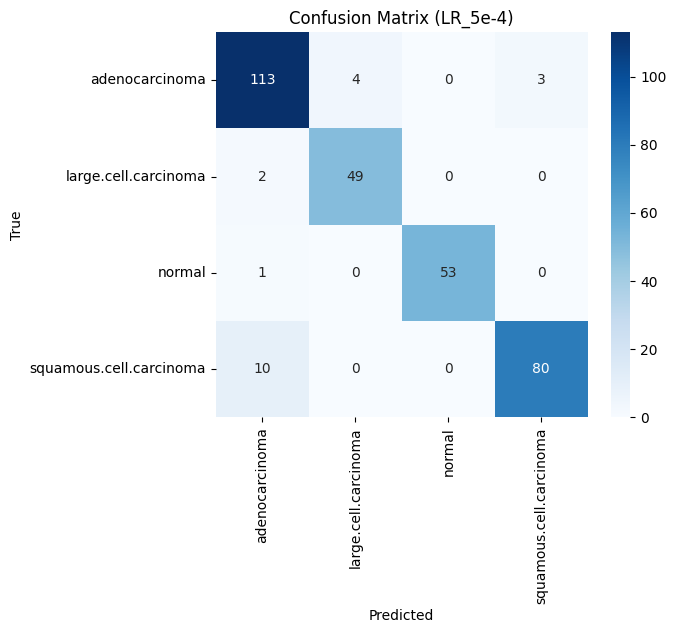

                         precision    recall  f1-score   support

         adenocarcinoma       0.90      0.94      0.92       120
   large.cell.carcinoma       0.92      0.96      0.94        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.96      0.89      0.92        90

               accuracy                           0.94       315
              macro avg       0.95      0.94      0.94       315
           weighted avg       0.94      0.94      0.94       315


📊 LR_1e-3 → Test Accuracy: 0.9365


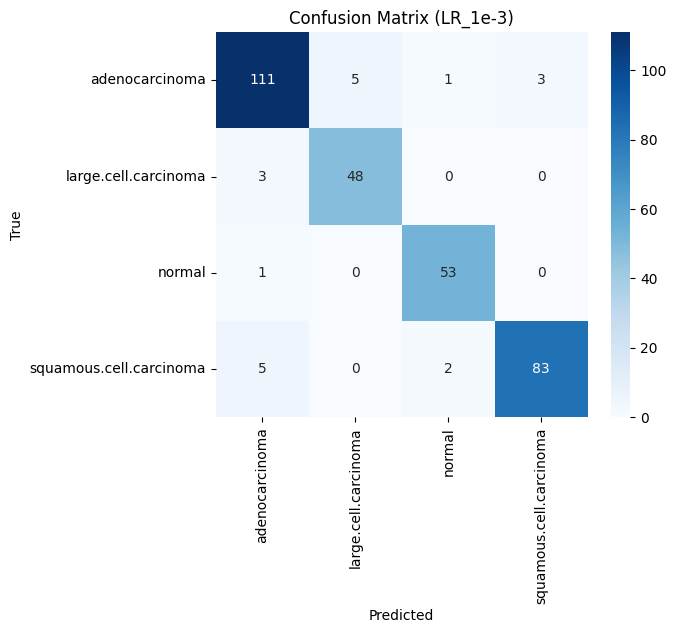

                         precision    recall  f1-score   support

         adenocarcinoma       0.93      0.93      0.93       120
   large.cell.carcinoma       0.91      0.94      0.92        51
                 normal       0.95      0.98      0.96        54
squamous.cell.carcinoma       0.97      0.92      0.94        90

               accuracy                           0.94       315
              macro avg       0.94      0.94      0.94       315
           weighted avg       0.94      0.94      0.94       315



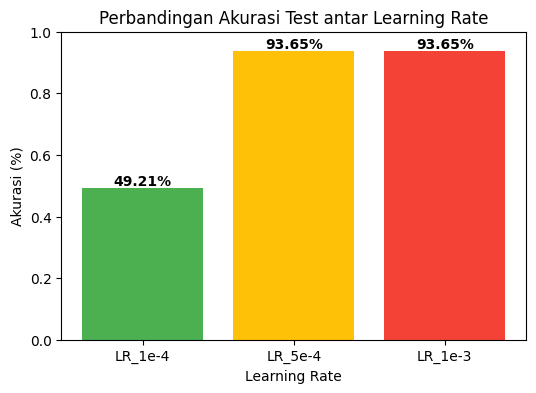

In [32]:
model_paths = {
    'LR_1e-4': '/kaggle/working/efficientformer_LearningRate/best_efficientformerv2_s2_0.0001.pth',
    'LR_5e-4': '/kaggle/working/efficientformer_LearningRate/best_efficientformerv2_s2_0.0005.pth',
    'LR_1e-3': '/kaggle/working/efficientformer_LearningRate/best_efficientformerv2_s2_0.001.pth'
}

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(
    root='/kaggle/input/chest-ctscan-images/Data/test',  
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

def evaluate_model(model_path, lr_label):
    # Load model
    model = timm.create_model('efficientformerv2_s2', pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n📊 {lr_label} → Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix ({lr_label})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=class_names))
    return acc

results = {}
for lr_label, model_path in model_paths.items():
    if os.path.exists(model_path):
        acc = evaluate_model(model_path, lr_label)
        results[lr_label] = acc
    else:
        print(f"⚠️ File model {model_path} tidak ditemukan!")

plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['#4CAF50','#FFC107','#F44336'])
plt.title('Perbandingan Akurasi Test antar Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Akurasi (%)')
plt.ylim(0,1)
for lr, acc in results.items():
    plt.text(lr, acc + 0.01, f"{acc*100:.2f}%", ha='center', fontsize=10, fontweight='bold')
plt.show()